In [1]:
# Bayesian linear model of Dissolved Oxygen
# Piracicaba river (São Paulo)
import pymc3 as pm
import numpy as np
import os
import pandas as pd

In [2]:
# load data from CSV file
DATA_DIR = "C:\Backup_Fernando\Fernando\Bayesian" 
planilha = os.path.join(DATA_DIR, "Rio_Piracicaba.csv")

df = pd.read_csv(planilha, sep=";", decimal=",", header=0)

# Standardize X predictors: autoscale

dOD = df['OD']
dDBO = (df['DBO'] - df['DBO'].mean()) / df['DBO'].std()
dTA = (df['Temp'] - df['Temp'].mean()) / df['Temp'].std()
dVZ = (df['Vazao'] - df['Vazao'].mean()) / df['Vazao'].std()
dPH = (df['pH'] - df['pH'].mean()) / df['pH'].std()
dFO = (df['Fosf'] - df['Fosf'].mean()) / df['Fosf'].std()
dNO3 = (df['NO3'] - df['NO3'].mean()) / df['NO3'].std()
dNO2 = (df['NO2'] - df['NO2'].mean()) / df['NO2'].std()
dNH3 = (df['NH3'] - df['NH3'].mean()) / df['NH3'].std()
dKJ = (df['Kje'] - df['Kje'].mean()) / df['Kje'].std()
dTU = (df['Turb'] - df['Turb'].mean()) / df['Turb'].std()


In [3]:
#linear model building
with pm.Model() as model:
    a = pm.Normal('a', mu=dOD.mean(), sd=10)
    bA = pm.Normal('bA', mu=0, sd=10, shape=10) # shape = No de bA's
    sigma = pm.Uniform('sigma', lower=0, upper=10) 
    mu = pm.Deterministic('mu', a + bA[0] * dDBO + bA[1] * dTA + bA[2] * dVZ + bA[3] * dPH + bA[4] * dNH3 + bA[5] * dFO
                          + bA[6] * dNO2 + bA[7] * dNO3 + bA[8] * dKJ + bA[9] * dTU)
   
    OD = pm.Normal('OD', mu=mu, sd=sigma, observed=dOD)
    trace = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bA, a]
Sampling 2 chains: 100%|███████████████| 4000/4000 [00:39<00:00, 102.14draws/s]


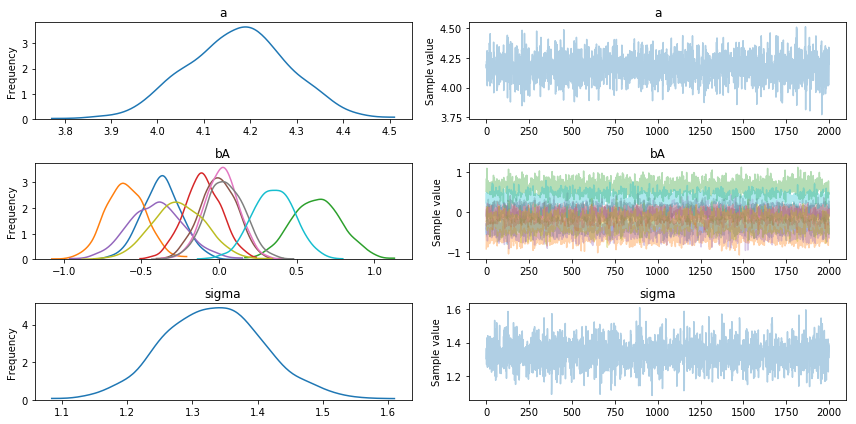

In [4]:
varnames = ['a', 'bA', 'sigma']
pm.traceplot(trace, varnames, combined=True);


In [5]:
pm.summary(trace, varnames, alpha=.11).round(3)


,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
a,4.171,0.109,0.002,4.005,4.351,3621.904,1.000
bA__0,-0.371,0.124,0.002,-0.566,-0.174,3021.598,1.000
bA__1,-0.604,0.129,0.002,-0.788,-0.387,2247.041,1.000
bA__2,0.627,0.159,0.004,0.373,0.884,1976.392,1.000
bA__3,-0.107,0.120,0.002,-0.292,0.092,2273.621,1.000
bA__4,-0.406,0.175,0.004,-0.691,-0.140,1812.739,1.000
bA__5,-0.006,0.119,0.002,-0.203,0.177,3414.213,1.000
bA__6,0.015,0.110,0.002,-0.142,0.207,3630.310,1.000
bA__7,0.038,0.124,0.002,-0.138,0.248,2303.097,1.000
bA__8,-0.261,0.172,0.004,-0.557,-0.011,1646.861,0.999


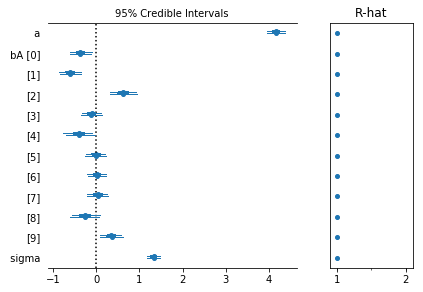

In [7]:
pm.forestplot(trace, varnames=varnames);

In [12]:
OD_pred = pm.sample_posterior_predictive(trace, samples=1000, model=model)['OD']

100%|█████████████████████████████████████| 1000/1000 [00:03<00:00, 252.10it/s]


In [13]:
# Save the DO results as text file
np.savetxt('OD_pred.txt', OD_pred.mean(0), delimiter=' ', newline='\n')